In [1]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import cv2

import matplotlib.pyplot as plt 
%matplotlib inline

import newscripts

Using TensorFlow backend.


In [2]:
## Data loading, and standardizing

trainData = "../../Data/Kather_all"

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(trainData, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        new_train.append(np.asarray( resized_image, dtype="uint8" ))
        image_names.append(filename)

meanMatrix = np.asarray(new_train) # NP array
meanMatrix = meanMatrix.astype('float32') / 255. # Normalize the values for the network
print(meanMatrix.shape)


(5000, 96, 96, 3)


In [15]:
## Labels loading

## capture true labels
## In the same order as predicted labels

directory_with_labels = "../../Data/Kather_5000"
labels_true = []

for image in image_names:
    for direct in os.listdir(directory_with_labels):
        if direct != ".DS_Store":
            if image in os.listdir(os.path.join(directory_with_labels,direct)):
                labels_true.append(int(direct.split("_")[0]))


In [3]:
autoencoder = load_model('../Autoencoders/SavedModels/fulldata_checkpoint_epochs10000_batch32_adam.h5') # 6 x 6 x 16

In [4]:
layer_name = 'conv2d_7' # 6 x 6 x 16

intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

X = intermediate_layer_model.predict(meanMatrix)
print(X.shape)



(5000, 6, 6, 16)


(5000, 576)
(5000, 576)
HC Silhouette Score  0.2036329060792923 
kmeans Silhouette Score  0.2188563048839569 
gmm Silhouette Score  0.17913313210010529 


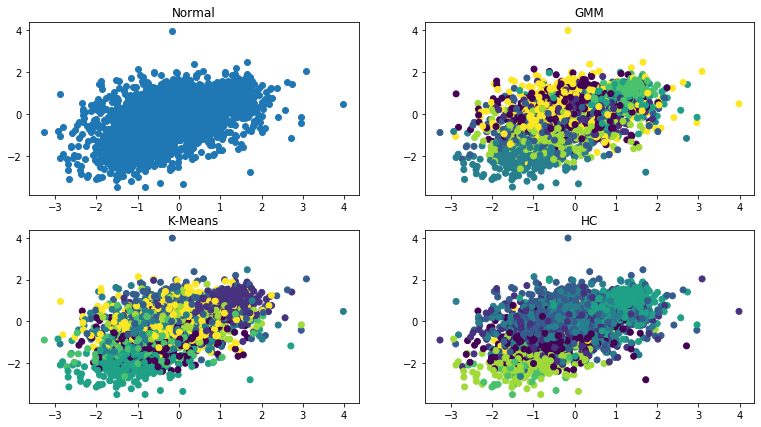

72
73


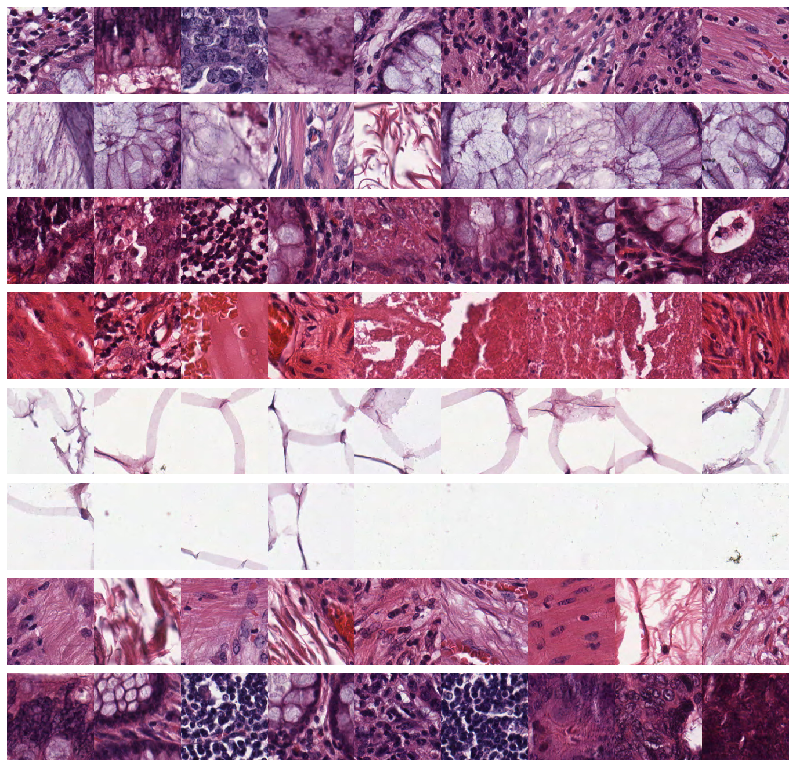

In [5]:
n_images = X.shape[0]
X = X.reshape((n_images, -1))
print(X.shape)

scaler = StandardScaler()
scaledkather = scaler.fit_transform(X)

Labels = newscripts.ClusterAndPlot(8, scaledkather)
newscripts.clusterintoDirectories(Labels[2], trainData, image_names)
newscripts.pltPathologyClusters(Labels[2], trainData)


In [40]:
def evaluateAll3withLabels(Labels, labels_true):

    summ = 0
    algo_list = []

    for algo in Labels: # Labels has a length 3, HC is 0, KMeans is 1, GMM is 2
        summ += metrics.adjusted_mutual_info_score(algo, labels_true)
        summ += metrics.homogeneity_score(algo, labels_true)
        summ += metrics.adjusted_rand_score(algo, labels_true)
        summ += metrics.completeness_score(algo, labels_true)
        summ += metrics.v_measure_score(algo, labels_true)
        algo_list.append(summ / 5) # append the average
        summ = 0

    print(algo_list)

    idx = algo_list.index(max(algo_list))
    if idx == 0:
        algo_name = "HC"
    elif idx == 1:
        algo_name = "KMeans"
    elif idx == 2:
        algo_name = "GMM"
    
    print(idx)
    
    print("{} Adjusted Rand index {}".format(algo_name,metrics.adjusted_mutual_info_score(labels_true, Labels[idx])))
    print("{} homogeneity_score {}".format(algo_name,metrics.homogeneity_score(labels_true, Labels[idx])))
    print("{} adjusted_rand_score {}".format(algo_name,metrics.adjusted_rand_score(Labels[idx],labels_true)))
    print("{} completeness_score {}".format(algo_name,metrics.completeness_score(labels_true, Labels[idx])))
    print("{} v_measure_score {}".format(algo_name,metrics.v_measure_score(labels_true, Labels[idx], beta=0.6)))



In [41]:
# evaluatewithLabels(Labels[2], labels_true)
evaluateAll3withLabels(Labels, labels_true)

[0.33494612797583584, 0.49828825102486374, 0.4589612790261205]
1
KMeans Adjusted Rand index 0.5232119139520433
KMeans homogeneity_score 0.5125530509403005
KMeans adjusted_rand_score 0.39457697408873404
KMeans completeness_score 0.536734282384901
KMeans v_measure_score 0.5213612907327019


In [34]:
evaluatewithLabels(Labels[1], labels_true)

Adjusted Rand index 0.5232119139520434
homogeneity_score 0.5125530509403005
adjusted_rand_score 0.39457697408873404
completeness_score 0.536734282384901
v_measure_score 0.5213612907327019


In [42]:
# PCA 
pca = PCA(n_components=0.95)
transformedData = pca.fit_transform(scaledkather)
pca.n_components_

173

(5000, 173)
HC Silhouette Score  0.056286558508872986 
kmeans Silhouette Score  0.23192258179187775 
gmm Silhouette Score  0.15301650762557983 


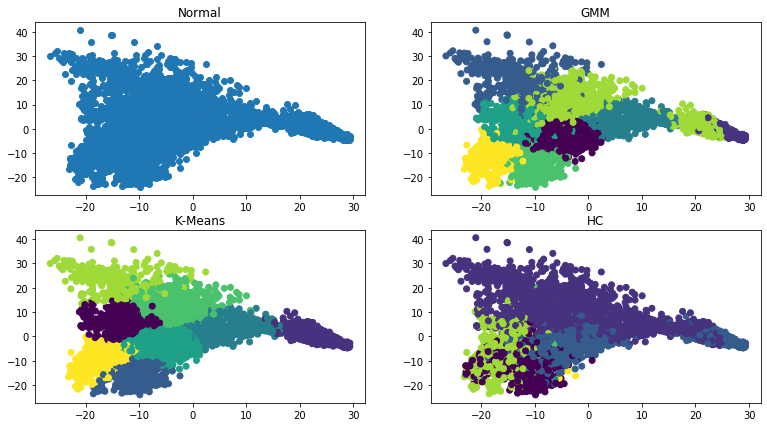

72
73


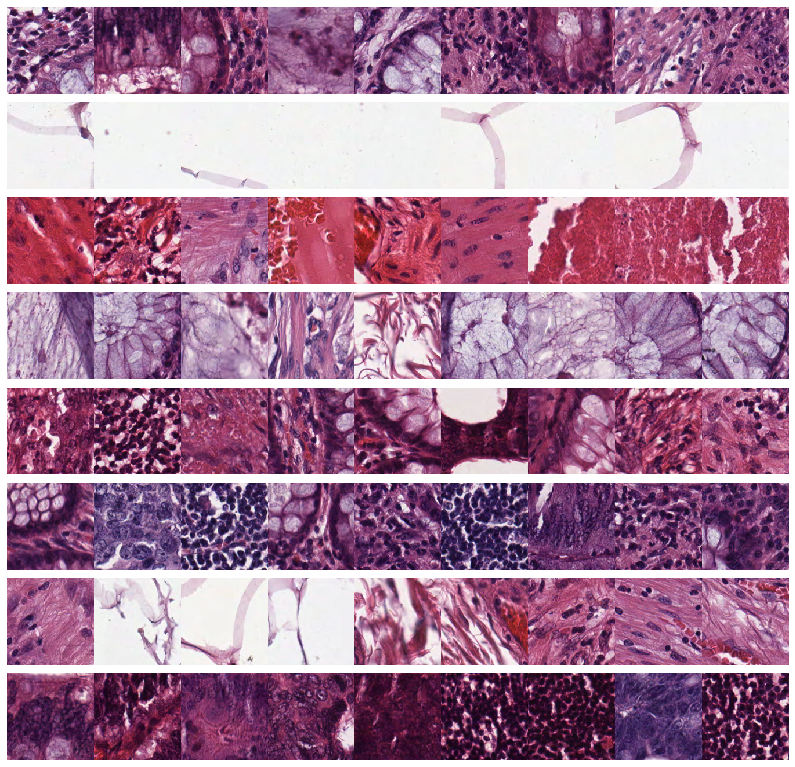

In [43]:
Labels = newscripts.ClusterAndPlot(8, transformedData)
newscripts.clusterintoDirectories(Labels[2], trainData, image_names)
newscripts.pltPathologyClusters(Labels[2], trainData)

In [44]:
evaluateAll3withLabels(Labels, labels_true)

[0.33494612797583584, 0.49828825102486374, 0.45827487034753156]
1
KMeans Adjusted Rand index 0.5232119139520433
KMeans homogeneity_score 0.5125530509403005
KMeans adjusted_rand_score 0.39457697408873404
KMeans completeness_score 0.536734282384901
KMeans v_measure_score 0.5213612907327019


In [45]:
evaluatewithLabels(Labels[2], labels_true)

Adjusted Rand index 0.485548580995122
homogeneity_score 0.4815074417124101
adjusted_rand_score 0.3453758311658308
completeness_score 0.4921647343388852
v_measure_score 0.48544939644240165


In [ ]:
# d = {'id': image_names, 'label': true_labels}
# df_new = pd.DataFrame(data=d)
# df_new.to_csv(r'../../Data/Kather_5000/katherLabels.csv')

In [19]:
# labels_true = true_labels
# labels_pred = Labels[1]

def evaluatewithLabels(labels_pred, labels_true):
    print("Adjusted Rand index {}".format(metrics.adjusted_mutual_info_score(labels_pred, labels_true)))
    print("homogeneity_score {}".format(metrics.homogeneity_score(labels_true, labels_pred)))
    print("adjusted_rand_score {}".format(metrics.adjusted_rand_score(labels_true,labels_pred)))
    print("completeness_score {}".format(metrics.completeness_score(labels_true, labels_pred)))
    print("v_measure_score {}".format(metrics.v_measure_score(labels_true, labels_pred, beta=0.6)))

In [ ]:
tsne3 = TSNE(n_components=2, perplexity = 50).fit_transform(transformedData)
kmeans3 = KMeans(n_clusters=9).fit(tsne3)

plt.scatter(tsne3[:, 0], tsne3[:, 1], c=kmeans3.labels_, cmap='viridis')
# plt.set_title('perplexity = 50')

In [ ]:
autoencoderRG = load_model('../Autoencoders/SavedModels/new_mean_squared_error_epochs300_batch64.h5') # 6 x 6 x 16

In [ ]:
layer_name = 'conv2d_115' # 6 x 6 x 32

intermediate_layer_model = Model(inputs=autoencoderRG.input, outputs=autoencoderRG.get_layer(layer_name).output)

X = intermediate_layer_model.predict(meanMatrix)
print(X.shape)

n_images = X.shape[0]
X = X.reshape((n_images, -1))
print(X.shape)

Labels = ClusterAndPlot(8, X)
clusterintoDirectories(Labels[1])
valMse = pltPathologyClusters(Labels[1])
valMse

In [ ]:
# labels_true = true_labels
# labels_pred = Labels[1]

evaluatewithLabels(Labels[1], true_labels)

In [ ]:
# PCA 
# pca = PCA(n_components=0.80)
pca = PCA(n_components=2)
transformedData = pca.fit_transform(X)
pca.n_components_

In [ ]:
Labels = ClusterAndPlot(8, transformedData)
clusterintoDirectories(Labels[1])
pltPathologyClusters(Labels[1])


In [ ]:
evaluatewithLabels(Labels[1], true_labels)

In [ ]:
evaluatewithLabels(Labels[0], true_labels)

In [ ]:
evaluatewithLabels(Labels[2], true_labels)